In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%reload_ext autoreload
%autoreload 2

# <span style='color:lightgreen'>Logs

In [18]:
model_id = 'USC_32_32'
lt_logs_df = pd.read_csv('./logs/long_term_forecast.csv', index_col = 0)
lt_logs_df['epoch'] = lt_logs_df['epoch'].fillna(-1).astype(int)
lt_logs_df['fit_time'] = np.round(lt_logs_df['fit_time'],2)
start_index = 232
query = (lt_logs_df['model_id'] == model_id)&(lt_logs_df['fde'].isna() == False)&(lt_logs_df.index >= start_index)
lt_logs_df[query][['model','features','input_features','seq_len', 'pred_len','e_layers','d_model', 'd_layers', 'd_ff',
       'dropout', 'learning_rate', 'train_epochs', 'epoch','fde','rmse','nb_params', 'fit_time']].sort_values('fde')#.head(20)

,model,features,input_features,seq_len,pred_len,e_layers,d_model,d_layers,d_ff,dropout,learning_rate,train_epochs,epoch,fde,rmse,nb_params,fit_time
276,SABFormer,MS,A,32,32,2,256,1,512,0.10,0.0010,36,17,2.849299,1.627774,6056608,1614.22
238,iTransformer,S,A,32,32,2,256,1,512,0.10,0.0010,36,35,2.938396,1.653507,1071392,114.67
250,Transformer,MS,A,32,32,1,128,1,128,0.25,0.0010,36,7,2.946575,1.711822,1589377,306.81
234,Transformer,S,A,32,32,2,256,1,512,0.10,0.0010,36,34,2.954257,1.663159,4446721,298.62
235,Transformer,MS,A,32,32,2,256,1,512,0.10,0.0010,36,16,2.954719,1.701583,4492801,303.14
240,PatchTST,S,A,32,32,2,256,1,512,0.10,0.0010,36,30,2.964681,1.676879,2372129,116.38
248,TimesNet,S,A,32,32,1,128,1,128,0.25,0.0010,36,36,2.965395,1.669762,10025793,606.06
271,Transformer,MS,A,32,32,2,256,1,512,0.20,0.0005,36,6,2.967244,1.719060,4492801,190.90
262,TimesNet,S,A,32,32,4,256,2,256,0.22,0.0010,36,36,2.967844,1.678596,151261761,6339.74
247,Nonstationary_Transformer,S,A,32,32,1,128,1,128,0.25,0.0010,36,26,2.968956,1.694405,1604545,291.38


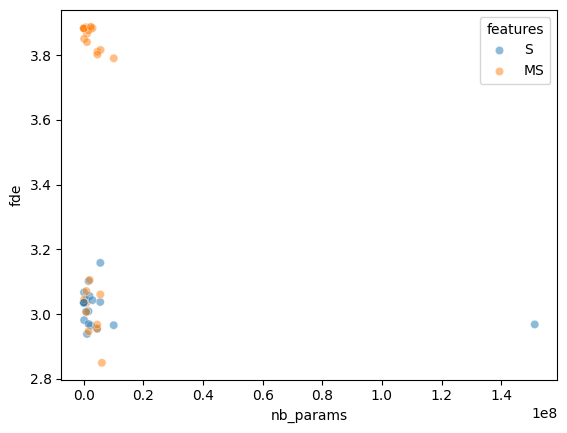

In [19]:
sns.scatterplot( data = lt_logs_df[query], 
                x = 'nb_params', y='fde', alpha = 0.5,
                hue= 'features');

### Scoring baselines

In [20]:
from types import SimpleNamespace
from data_provider.data_factory import data_provider

usc_args = SimpleNamespace(**lt_logs_df.loc[207].to_dict())
usc_args.scale = False
uscds, uscdl = data_provider(args= usc_args, flag = 'test', )
uscds.data_x.shape, uscds.data_y.shape

test 4233


((4233, 32, 1), (4233, 32, 1))

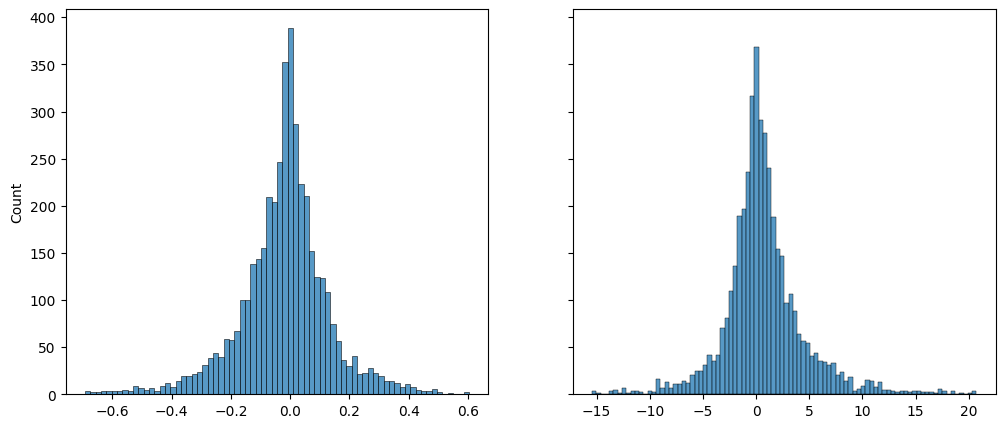

In [21]:
tmp = uscds.data_x[:,-1,0] -  uscds.data_y[:,0,0]
fig, axs = plt.subplots(1,2,figsize = (12,5), sharey=True)
sns.histplot(tmp, ax = axs[0]);
sns.histplot(uscds.data_y[:,-1,0], ax = axs[1]);


In [22]:
uscds.data_x[0,-5:,0] , uscds.data_y[0,:5,0]

(array([-0.5815458 , -0.4777832 , -0.3362279 , -0.13446379,  0.        ],
       dtype=float32),
 array([0.17934847, 0.41184092, 0.6160221 , 0.8721256 , 1.0302544 ],
       dtype=float32))

In [23]:
x,y = uscds.data_x, uscds.data_y

In [24]:
ind = 0
x[ind,-5:,0], y[ind,usc_args.label_len:usc_args.label_len+5,0]

(array([-0.5815458 , -0.4777832 , -0.3362279 , -0.13446379,  0.        ],
       dtype=float32),
 array([2.177392 , 2.1703014, 2.1655731, 2.1820927, 2.18682  ],
       dtype=float32))

In [25]:
ss_fde = np.sqrt(np.mean(uscds.data_y[:,-1,0]**2))
ss_rmse = np.sqrt(np.mean(uscds.data_y[:,:,0]**2))
ss_fde, ss_rmse

(3.8998787, 2.452531)

In [26]:
bl_cv_delta = uscds.data_x[:,-1,0] - uscds.data_x[:,-2,0]
bl_cv_pred = np.repeat(uscds.data_x[:,-1,0].reshape(-1,1,1), y.shape[1], axis=1)
for i in range(y.shape[1]):
    bl_cv_pred[:,i,0] = (i+1) * bl_cv_delta 
cv_fde = np.sqrt(np.mean( (uscds.data_y[:,-1,0] - bl_cv_pred[:,-1,0])**2 ))
cv_rmse = np.sqrt(np.mean( (uscds.data_y[:,:,0] - bl_cv_pred[:,:,0])**2 ))
cv_fde, cv_rmse

(3.9323, 2.0943015)

In [27]:
bls = [{'model':'Baseline - StandStill', 'features':'S','fde':ss_fde, 'rmse':ss_rmse},
       {'model':'Baseline - ConstantVelocity', 'features':'S','fde':cv_fde, 'rmse': cv_rmse}]

### Comparison

In [28]:
tmp_df = lt_logs_df[query][['model','features','fde','rmse']].copy().sort_values(by = 'fde')
tmp_df['dupl'] = tmp_df[['model','features']].duplicated()
tmp_df=tmp_df[tmp_df['dupl'] == False]


In [29]:
comp = pd.concat([tmp_df.drop(columns = 'dupl'), pd.DataFrame(bls)]).reset_index(drop=True)
comp.sort_values(by = 'fde').round(3)

,model,features,fde,rmse
0,SABFormer,MS,2.849,1.628
1,iTransformer,S,2.938,1.654
2,Transformer,MS,2.947,1.712
3,Transformer,S,2.954,1.663
4,PatchTST,S,2.965,1.677
5,TimesNet,S,2.965,1.670
6,Nonstationary_Transformer,S,2.969,1.694
7,LSTM,MS,3.006,1.788
8,DLinear,S,3.035,1.707
9,LSTM,S,3.043,1.790


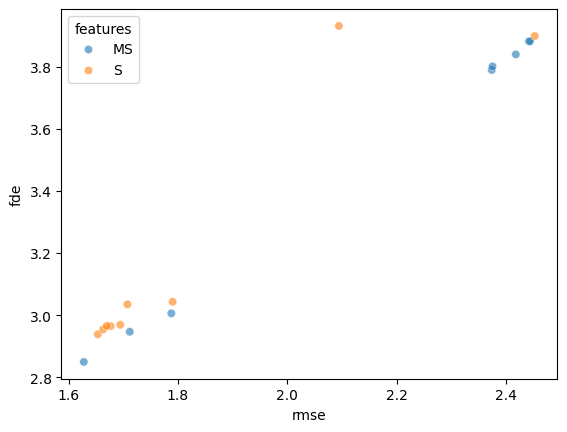

In [30]:
sns.scatterplot(data=comp, x = 'rmse', y = 'fde', hue = 'features', alpha = 0.6);